In [1]:
# demo de-noising using fhmm
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/fhmm', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [5]:
import librosa
import torchaudio
import numpy as np
import config
import os.path
import math
import os
import pathlib
import random
import torch
import utils
import warnings
import my_torch.torchio as tio
import torchaudio.functional as F
import torchaudio.transforms as T

In [6]:
# noise examples
fs = 4000

In [7]:

def noise_file_to_audio(noise_dir, sample_rate):
    effects = [
        ['remix', '1'],  # convert to mono
        ['rate', str(sample_rate)],  # resample
        ['gain', '-n']  # normalises to 0dB
    ]
    noise, sr = torchaudio.sox_effects.apply_effects_file(noise_dir, effects, normalize=True)
    return noise, sr

In [8]:
from whale.setup import get_data, constants, annotations

get_data_whale = get_data.GetDataBase(
    location_of_wav_file=constants.HUMPBACK_WAV_A,
    location_of_annotations=constants.SWOOPS_LABELS_A,
    annotations=annotations.AnnotationsAudacity(),
    window_length=0.025, frame_step=0.01, samples=False, sr=None)

whale_audio, _ = noise_file_to_audio(get_data_whale.location_of_wav_file, 4000)
whale_audio_numpy = whale_audio.numpy().flatten()

In [9]:
# log power seems to work better than magnitude
def get_feature(sample, nfft):
    return np.log(np.square(np.abs(librosa.stft(sample, n_fft=nfft)).T))

In [10]:
# create labels and data
whale_samples = []
whale_features = []
nfft = 256

for i in range(len(get_data_whale.annotations.annotations)):
    annot = get_data_whale.annotations.annotations[i]
    sample = whale_audio_numpy[annot.start:annot.end]
    whale_samples.append(sample)
    whale_features.append(get_feature(sample, nfft))

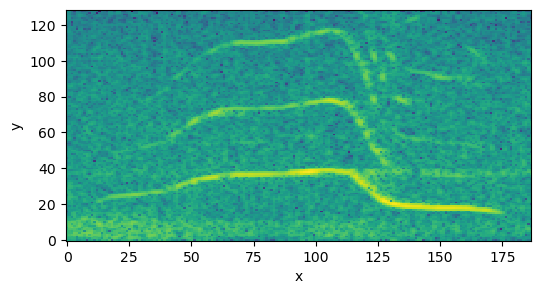

In [73]:
from final.useful import *
from hmmlearn.hmm import GaussianHMM
vis_helper(whale_features[0])
# train hmm
hmm_whale = GaussianHMM(10)

In [74]:
hmm_whale.fit(np.concatenate(whale_features))

GaussianHMM(n_components=10)

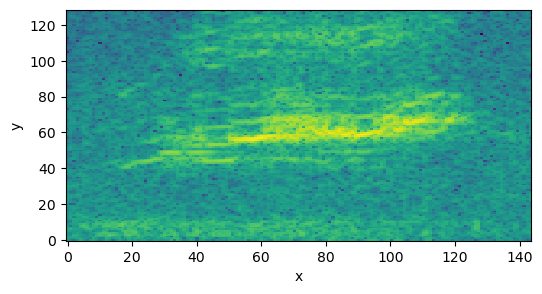

GaussianHMM(n_components=10)

In [75]:
get_data_whale_hc = get_data.GetDataBase(
    location_of_wav_file=constants.HUMPBACK_WAV_A,
    location_of_annotations=constants.HIGH_CALLS_LABELS_A,
    annotations=annotations.AnnotationsAudacity(),
    window_length=0.025, frame_step=0.01, samples=False, sr=None)

whale_hc_samples = []
whale_hc_features = []
nfft = 256

for i in range(len(get_data_whale_hc.annotations.annotations)):
    annot = get_data_whale_hc.annotations.annotations[i]
    sample = whale_audio_numpy[annot.start:annot.end]
    whale_hc_samples.append(sample)
    whale_hc_features.append(get_feature(sample, nfft))

vis_helper(whale_hc_features[4])
# tio.play_audio(torch.from_numpy(whale_hc_samples[0][..., np.newaxis]), sample_rate=fs)
hmm_whale_hc = GaussianHMM(10)
hmm_whale_hc.fit(np.concatenate(whale_hc_features))

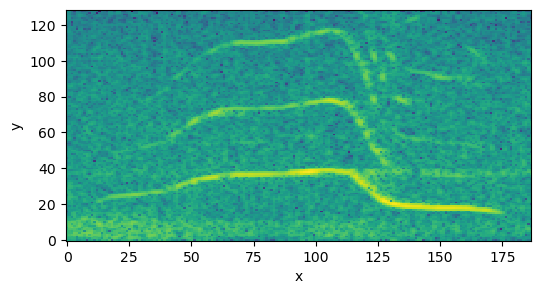

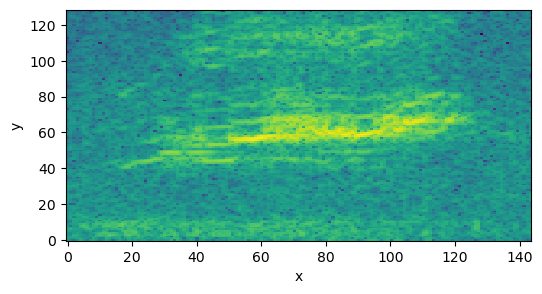

In [45]:
# time domain combine
import matplotlib.pyplot as plt
whale_sample = whale_samples[0]
vis_helper(whale_features[0])
utils.get_average_power(whale_sample, False, False)
vis_helper(whale_hc_features[4])

In [38]:
def add_matrices(matrix1, matrix2):
     # Check if matrices are 1D arrays
    if matrix1.ndim == 1:
        matrix1 = matrix1.reshape(1, -1)
    if matrix2.ndim == 1:
        matrix2 = matrix2.reshape(1, -1)
    # Get the dimensions of the matrices
    rows1, cols1 = matrix1.shape
    rows2, cols2 = matrix2.shape

    # Determine the maximum dimensions
    max_rows = max(rows1, rows2)
    max_cols = max(cols1, cols2)

    # Create matrices with zeros and copy the values
    padded_matrix1 = np.zeros((max_rows, max_cols))
    padded_matrix2 = np.zeros((max_rows, max_cols))

    padded_matrix1[:rows1, :cols1] = matrix1
    padded_matrix2[:rows2, :cols2] = matrix2

    # Add the matrices together
    result_matrix = padded_matrix1 + padded_matrix2

    return result_matrix[0,:]


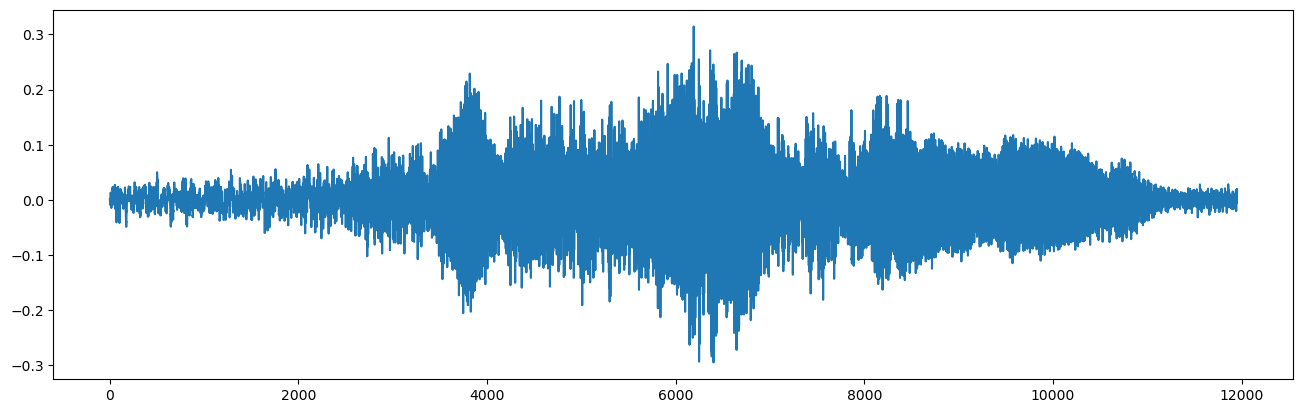

In [68]:
combined_time_domain = add_matrices(whale_samples[0], np.concatenate((np.zeros(2000), whale_hc_samples[0]), axis=0))
plt.plot(combined_time_domain, label='Combined')

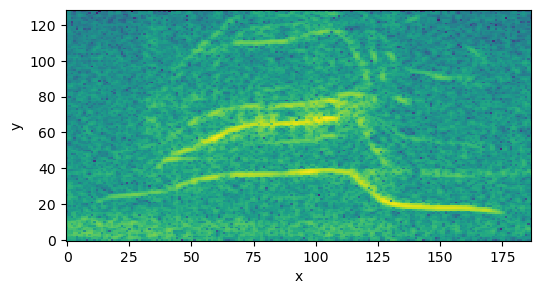

In [71]:
combined_feature = get_feature(combined_time_domain, nfft)
vis_helper(combined_feature)

In [76]:
import hmmUtils
from importlib import reload
reload(hmmUtils)
ViterbiAlgorithmParallel = hmmUtils.doViterbiAlgorithmParallel(combined_feature, hmm_whale, hmm_whale_hc)

In [77]:
reload(hmmUtils)
# switch to the
p1 = hmmUtils.inputParams(hmm_whale.means_, ViterbiAlgorithmParallel[1][0])
p2 = hmmUtils.inputParams(hmm_whale_hc.means_, ViterbiAlgorithmParallel[1][1])

mask01, mask02 = hmmUtils.weinerFilter.getSoftMask(combined_feature, p1, p2, alpha=1)

whale_recovered = ((np.exp(combined_feature)) * mask01)
noise_recovered = ((np.exp(combined_feature)) * mask02)

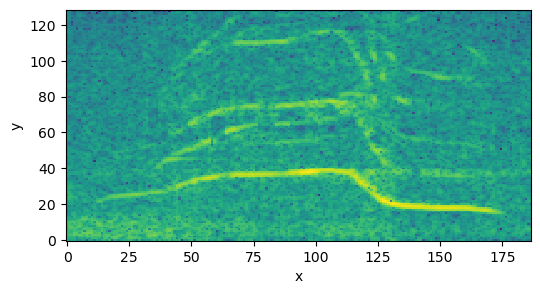

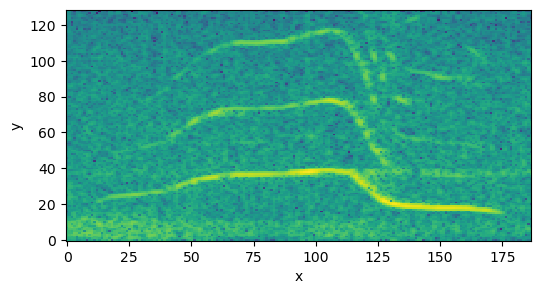

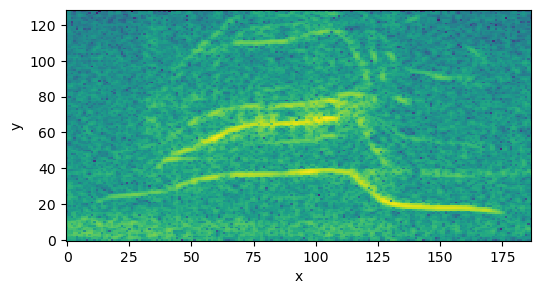

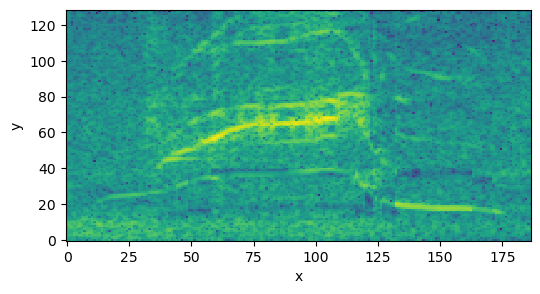

In [82]:
vis_helper(np.log(whale_recovered))
vis_helper(whale_features[0])
vis_helper(combined_feature)
vis_helper(np.log(noise_recovered))

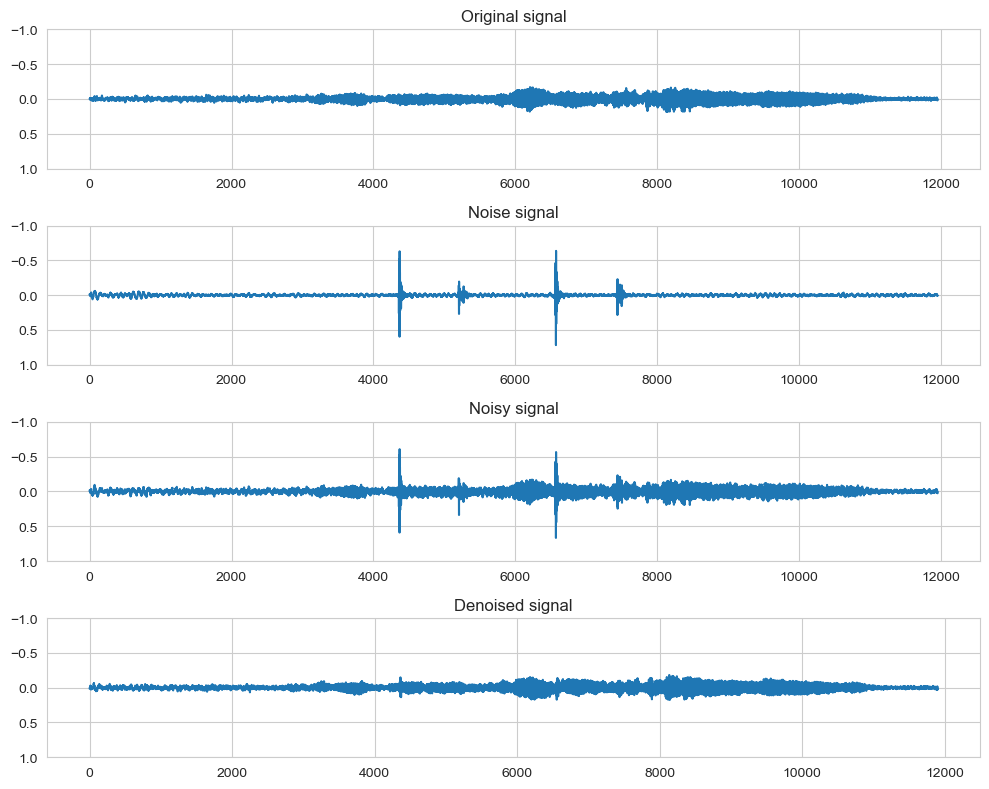

In [66]:
# listen to recovered signal

reload(utils)
ylim = [1, -1]

whale_recovered_stft = np.sqrt(whale_recovered)
whale_recovered_time_domain = librosa.griffinlim(whale_recovered_stft.T, n_fft=nfft)

# Set figure size
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

# Original signal
axs[0].plot(whale_sample)
axs[0].set_title('Original signal')
axs[0].set_ylim(ylim)  # Set y-axis limits

# Noise signal
axs[1].plot(noise_time_reduced[0:len(whale_sample)])
axs[1].set_title('Noise signal')
axs[1].set_ylim(ylim)  # Set y-axis limits

# Noisy signal
axs[2].plot(combined_sample_time_domain)
axs[2].set_title('Noisy signal')
axs[2].set_ylim(ylim)  # Set y-axis limits

# Denoised signal
axs[3].plot(whale_recovered_time_domain)
axs[3].set_title('Denoised signal')
axs[3].set_ylim(ylim)  # Set y-axis limits

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

import soundfile as sf
sf.write('whale_sample_original.wav', whale_sample, fs , 'PCM_24')
sf.write('whale_sample_combined.wav', combined_sample_time_domain, fs , 'PCM_24')
sf.write('whale_sample_de-noise.wav', whale_recovered_time_domain, fs , 'PCM_24')


In [54]:
from scipy.signal import correlate

def align_signals(original, recovered):
    """
    Align the recovered signal with the original signal using cross-correlation.

    Parameters:
    original (numpy.ndarray): Original signal.
    recovered (numpy.ndarray): Recovered signal.

    Returns:
    numpy.ndarray: Aligned recovered signal.
    """
    # Calculate cross-correlation
    xcorr = correlate(recovered, original, mode='full')

    # Find the index of the maximum correlation
    delay = np.argmax(xcorr) - (len(original) - 1)
    print(delay)

    # Apply the time shift to align the signals
    aligned_recovered = np.roll(recovered, -delay)

    return aligned_recovered

aligned_recovered = align_signals(whale_sample[:len(whale_recovered_time_domain)], whale_recovered_time_domain)


-112


In [55]:
def mean_squared_error(original, recovered):
    """
    Calculate Mean Squared Error (MSE) between two signals.

    Parameters:
    original (numpy.ndarray): Original signal.
    recovered (numpy.ndarray): Recovered signal.

    Returns:
    float: Mean Squared Error.
    """
    if original.shape != recovered.shape:
        raise ValueError("Input signals must have the same shape.")

    mse = np.mean((original - recovered)**2)
    return mse

print(mean_squared_error(whale_sample[:len(whale_recovered_time_domain)], combined_sample_time_domain[:len(whale_recovered_time_domain)]))
print(mean_squared_error(whale_sample[:len(whale_recovered_time_domain)], aligned_recovered))


0.0006811544
0.0024552778533103664


In [ ]:
whale_sample_tensor = torch.from_numpy(whale_sample[np.newaxis, ...])

tio.play_audio(whale_sample_tensor, fs)
tio.play_audio(torch.from_numpy(whale_recovered_time_domain[np.newaxis, ...]), fs)
tio.play_audio(torch.from_numpy(combined_sample_time_domain[np.newaxis, ...]), fs)

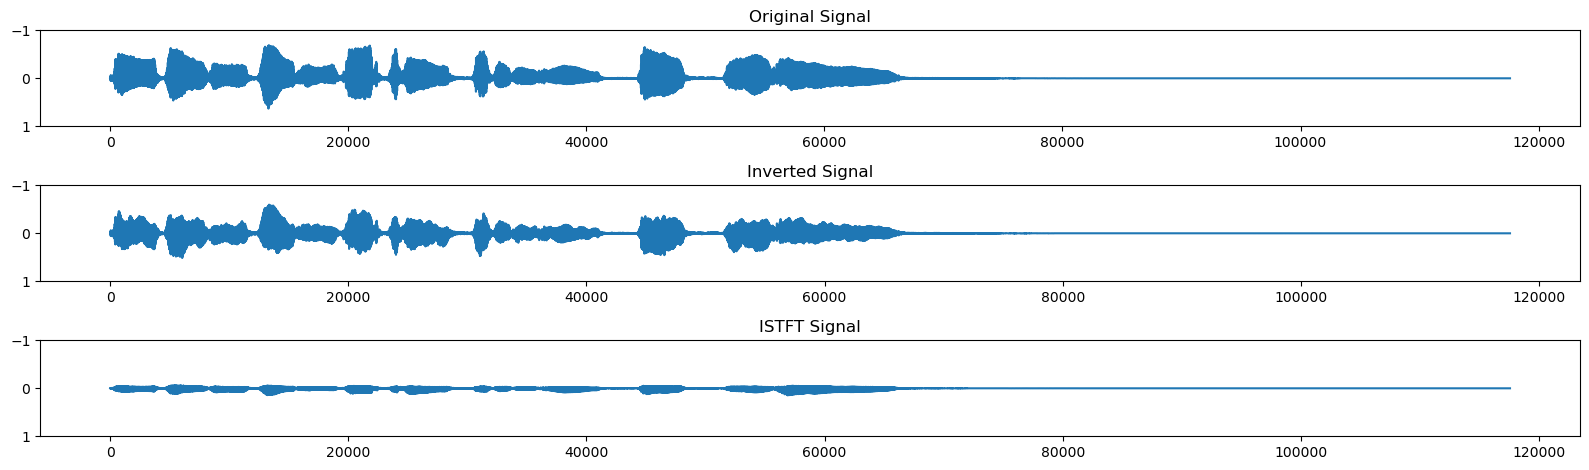

In [123]:
y, sr = librosa.load(librosa.ex('trumpet'))
# Get the magnitude spectrogram
S = np.abs(librosa.stft(y, n_fft=256))
# Invert using Griffin-Lim
y_inv = librosa.griffinlim(S, n_fft=256)
# Invert without estimating phase
y_istft = librosa.istft(S, n_fft=256)


# Plot original signal

import matplotlib.pyplot as plt

plt.subplot(3, 1, 1)
plt.plot(y)
plt.title('Original Signal')
plt.ylim([1,-1])  # Set y-axis limits

# Plot inverted signal
plt.subplot(3, 1, 2)
plt.plot(y_inv)
plt.title('Inverted Signal')
plt.ylim([1,-1])  # Set y-axis limits

# Plot ISTFT signal
plt.subplot(3, 1, 3)
plt.plot(y_istft)
plt.title('ISTFT Signal')
plt.ylim([1,-1])  # Set y-axis limits

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()